# **Image Captioning Using a Neural Network**
As humans, we can easily describe an image in a sentence. How can a computer achieve the same task? The answer is by using a neural network!

# **Overview of Task**
In order to train a model to caption images, we must first describe to our model the features and the labels. In an ordinary classification task, our model will take an input and output its corresponding label. Training a model to caption images is no different. You might be wondering, how can we use the images as features to output a sentence as is our label? A caption can actually be treated as multiple labels for out image. For example, let's say we have this image.


---


![Sample Image](https://million-wallpapers.com/wallpapers/1/15/18092946989206152243.jpg)


---


One might caption  this image with, "A puppy playing with a ball in a field". We can treat this caption as multiple labels by separating the sentence into sequences that start at the first word "A" and incrementing one word from then on. This would look like the following -



1.   A
2.   A puppy
3.   A puppy playing
4.   A puppy playing with
5.   A puppy playing with a
6.   A puppy playing with a ball
7.   A puppy playing with a ball in
8.   A puppy playing with a ball in a
9.   A puppy playing with a ball in a field

Now, we can train a model to predict the next word based on the image and the given sequence. For example, if training has just started, the model would receive the image and "A" as the inputs. Then, the model tries to predict the next word. In this case, it is "puppy". The next input sequence would be "A puppy", and the model would try to predict "playing". Now, the model just has to continue this process and update based on its prediction.



# **Setup**
To begin our colab, we will first import the required modules.

In [0]:
%tensorflow_version 2.x
import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
import os
import json

In [0]:
import numpy as np

# **Dataset**
In this notebook, we will use the MSCOCO dataset which includes captions along with their images, perfect for our task. First, we load in the JSON file which includes the names of the images and their captions.

In [0]:
annotation_zip = tf.keras.utils.get_file("captions.zip",
                                          cache_subdir="/content/save",
                                          origin = "http://images.cocodataset.org/annotations/annotations_trainval2014.zip",
                                          extract = True)

252878848/252872794 [==============================] - 3s 0us/step


In [0]:
image_zip = tf.keras.utils.get_file("train2014.zip",
                                      cache_subdir="/content/save",
                                      origin = "http://images.cocodataset.org/zips/train2014.zip",
                                      extract = True)

13510574080/13510573713 [==============================] - 210s 0us/step


In [0]:
captions_file = open("/content/save/annotations/captions_train2014.json", "r")
annotations = json.load(captions_file)

After loading in the JSON file, we can create a list of the captions and the image names that go along with them. Here, we will only use 5000 images due to the limitations of Colab with training.

In [0]:
captions = []
img_names = []

for annotation in annotations["annotations"][:10000]:
    caption = "<start> " + annotation["caption"] + " <end>"
    image_id = annotation["image_id"]
    image_path = "/content/save/train2014/COCO_train2014_" + '%012d.jpg' % (image_id)

    img_names.append(image_path)
    captions.append(caption)

Now, we will use a tokenizer to convert each word in the captions list to an integer value. Afterwords, we will be padding the sentences that we converted to a sequence of integers with zeros. Because of this, we also have to add an index for `<pad>` in our tokenizer. Then, we have to find the longest sequence in our captions so that we don't go over the sentence length when training and predicting.


In [0]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=5000, oov_token="<unk>", filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(captions)
seqs = tokenizer.texts_to_sequences(captions)
tokenizer.index_word[0] = "<pad>"
tokenizer.word_index["<pad>"] = 0

In [0]:
max_seq_len = max([len(seq) for seq in seqs])

# **Preprocessing**
In this notebook, we will use the InceptionV3 model to extract features to train on. This model was chosen as it was demonstrated in the Show and Tell paper linked [here](https://arxiv.org/abs/1411.4555). The model architecture is described below.


---


![alt text](https://miro.medium.com/max/960/1*gqKM5V-uo2sMFFPDS84yJw.png)


---

From the description, we need to resize images to 299 x 299 pixels to extract features. We also do not need the classification layer so we will remove it from feature extraction. Thus, we include everything from the input layer to the last convolutional layer. The features we extract will be of size `(1, 2048)` due to the batch size, but we can use Tensorflow to reshape the tensor into the shape `(2048,)`.



In [0]:
encoder = tf.keras.applications.inception_v3.InceptionV3(weights="imagenet")

96116736/96112376 [==============================] - 2s 0us/step


In [0]:
inputs = encoder.input
output = encoder.layers[-2].output
features_model = tf.keras.Model(inputs=inputs, outputs=output)

In [0]:
def preprocess(img_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.expand_dims(img, axis=0)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    feature = features_model.predict(img)
    feature = tf.reshape(feature, (feature.shape[1],))
    return feature

Here, we will check to make sure that our preprocessing function correctly outputs a vector of length 2048.

In [0]:
ft = preprocess(img_names[0])

# **Generate Features**
Now, we can define a generator that will create the inputs and labels for our model. The code below demonstrates the process of converting captions into multiple sequences which we can use along with our image feature to predict the next word.

In [0]:
def data_generator(captions, img_path, max_length, batchsize=5, epochs=1):
  ftr_train = []
  seq_train = []
  lbls = []
  for epoch in range(epochs):
    for j, img in enumerate(img_path):
      ftr = preprocess(img)
      seq = captions[j]
      for i in range(1, len(seq)):
        input_seq = seq[:i]
        output_seq = seq[i]
        input_seq = tf.keras.preprocessing.sequence.pad_sequences(sequences=[input_seq], maxlen=max_seq_len, padding="post")[0]
        output_seq = tf.keras.utils.to_categorical([output_seq], num_classes=5001)[0]
        ftr_train.append(ftr)
        seq_train.append(input_seq)
        lbls.append(output_seq)
      if (j + 1) % (batchsize) == 0:
        yield [np.array(ftr_train), np.array(seq_train)], np.array(lbls)
        ftr_train = []
        seq_train = []
        lbls = []

# **Model**
After creating our generator, we can create the model for generating captions. Note that the input layers, `inputs1` and `inputs2` correspond to our image and sequence. We have to add these layers after processing them in the model.

In [0]:
inputs1 = tf.keras.layers.Input(shape=(2048,))
layer1 = tf.keras.layers.Dense(256, activation="relu")(inputs1)
inputs2 = tf.keras.layers.Input(shape=(max_seq_len,))
layer2 = tf.keras.layers.Embedding(5001, 256, mask_zero=True)(inputs2)
layer3 = tf.keras.layers.LSTM(256)(layer2)
out = tf.keras.layers.Add()([layer1, layer3])
out = tf.keras.layers.Dense(256, activation="relu")(out)
out = tf.keras.layers.Dense(5001, activation="softmax")(out)
model = tf.keras.Model(inputs=[inputs1, inputs2], outputs=[out])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 33)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 33, 256)      1280256     input_3[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          524544      input_2[0][0]                    
____________________________________________________________________________________________

After creating our model, we will compile it and specify the necessary parameters below. Finally, we can begin training on our model.

In [0]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [0]:
batch_size = 32
steps = 10000//batch_size
generator = data_generator(seqs, img_names, max_seq_len, batch_size, epochs=2)
history = model.fit(generator, steps_per_epoch=steps, epochs=2, shuffle=True)

In [0]:
model.save("caption_model.h5")

# **Create Captions**
Now that we have trained our model, we can use it to generate captions. Below, we create our function. Inside, we pass in the image we want to caption and begin the sequence with `<start>`. After each prediction with the model, we pass in our initial sequence but this time, we add the predicted word that our model generates. This continues to iterate until we hit the `<end>` sequence or the length of the caption is hit.

In [0]:
def generate_caption(img_path):
    img_ftr = preprocess(img_path)
    img_ftr = tf.reshape(img_ftr, (1, 2048))
    start_seq = "<start>"
    for i in range(max_seq_len):
        seq = [tokenizer.word_index[word] for word in start_seq.split()]
        seq = tf.keras.preprocessing.sequence.pad_sequences([seq], maxlen=max_seq_len)
        pred = model.predict([img_ftr, seq])
        index = tf.argmax(pred, axis=-1)
        index = index.numpy()[0]
        word = tokenizer.index_word[index]
        start_seq += " " + word
        if word == "<end>":
            break
    sentence = start_seq.split()
    sentence = sentence[1:-1]
    sentence = " ".join(sentence)
    return sentence

In [0]:
caption_test = generate_caption(img_names[10])

Text(0.5, 1.0, 'a man is in a kitchen with a kitchen')

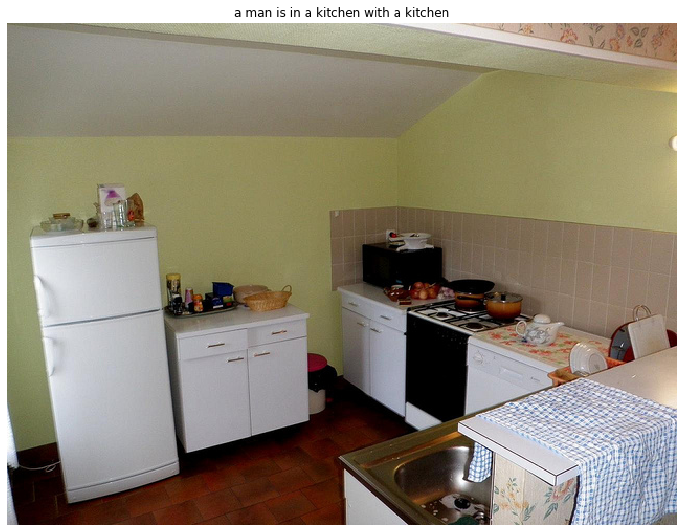

In [0]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
img = plt.imread(img_names[10])
plt.axis("off")
plt.imshow(img)
plt.title(caption_test)

# **Better Predictions**
There are many ways in which we can extend the capabilities of our model. In this notebook, we used only 5000 images due to training limitations. However, if able, you can increase the number of images to 10000 or even 30000 to give our model as much data as we can to train on. Furthermore, we can create a larger vocabulary for our tokenizer so that our captions are much more accurate. In addition, our model was trained on only one epoch. We can specify more epochs so that our model learns more information, but this notebook uses one to save time on training.

# **Image Links**

Puppy

---


https://www.google.com/url?sa=i&source=images&cd=&ved=2ahUKEwiV9fyz85znAhUpTd8KHdyoDdcQjRx6BAgBEAQ&url=https%3A%2F%2Fmillion-wallpapers.com%2Fanimals-137-android%2Fpuppy-playing-lawn-ball-grass-dog-11583.html&psig=AOvVaw2f3Ky_i6jQDnm_cr1OQldZ&ust=1579978136636463

Model Architecture

---


https://www.google.com/url?sa=i&source=images&cd=&cad=rja&uact=8&ved=2ahUKEwjN3ITT8pznAhUBy1kKHcIyD7gQjRx6BAgBEAQ&url=https%3A%2F%2Fmedium.com%2F%40sh.tsang%2Freview-inception-v3-1st-runner-up-image-classification-in-ilsvrc-2015-17915421f77c&psig=AOvVaw3-W1drM4RYfjmnpToJZIFJ&ust=1579977858655557